<a href="https://github.com/linogaliana/python-datascientist/blob/master/course/manipulation/03_geopandas_TP.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/course/manipulation/03_geopandas_TP.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)]("https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/course/manipulation/03_geopandas_TP.ipynb")
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)]("https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter
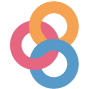

In [1]:
#| echo: false
#| output: 'asis'
#| include: true
#| eval: true

import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/manipulation/03_geopandas_TP.qmd")

Installations préalables : 


In [2]:
#| echo: true
#| include: true

!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas

In [3]:
#| echo: true

import geopandas as gpd

# Lire et enrichir des données spatiales

Dans cette partie, nous utiliserons la fonction suivante, qui facilite 
le téléchargement et le dézippage des données proposées sur `data.gouv`:


In [4]:
#| echo: true
#| include: true

import requests
import tempfile
import zipfile

temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
  with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

In [5]:
# 0) Chargement des packages utilisés dans la partie tutoriel
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

{{% box status="exercise" title="Exercice 1: lire et explorer la structure de fichiers géographiques" icon="fas fa-pencil-alt" %}}
1. Utiliser la fonction `download_unzip` avec l'url <https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12>
pour télécharger les données communales.
2. Importer le fichier avec la package `geopandas`
(si vous avez laissé les paramètres par défaut,
le fichier devrait
être à l'emplacement `temporary_location + "/borders/communes-20190101.json"`).
Vous pouvez le nommer `communes_borders`
3. Regarder les premières lignes des données. Identifier la différence avec
un DataFrame standard. 
4. Afficher l'attribut `crs` de `communes_borders`. Ce dernier contrôle la
transformation de l'espace tridimensionnel terrestre en une surface plane. 
5. Afficher les communes de l'Aveyron (département 12) et utiliser la méthode
`plot`
6. Réprésenter la carte de Paris : quel est le problème ?
{{% /box %}}


In [6]:
# 1) télécharger les données communales
url = "https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12"
download_unzip(url)

In [7]:
# 2) Importer le fichier
communes_borders = gpd.read_file(temporary_location + "/borders/communes-20190101.json")

In [8]:
# 3) Regarder les premières lignes
communes_borders.head()

In [9]:
# 4) Afficher le crs
communes_borders.crs

In [10]:
# 5) afficher les communes du département 12
communes_borders[communes_borders.insee.str.startswith("12")].plot()

In [11]:
# 6) Représenter la carte de Paris. Quel est le problème ?
communes_borders[communes_borders.insee.str.startswith("75")].plot()

En effet, on ne dispose ainsi pas des limites des arrondissements parisiens, ce
qui appauvrit grandement la carte de Paris. On peut les récupérer directement 
depuis le site d'open data du grand Paris
(cf. [tutoriel du chapitre précédent](geopandas)).


{{% box status="exercise" title="Exercice 2: compléter des données spatiales issues de sources différentes" icon="fas fa-pencil-alt" %}}


1. Importer les données de découpage des arrondissements parisiens à l'adresse
<https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr>
2. Vérifier sur une carte que les découpages des arrondissements sont bien présents
3. Vérifier l'attribut `crs`. Est-il cohérent avec celui des données communales ?
4. Retirer Paris du jeu de données communales et utiliser les arrondissements
pour enrichir (nommer l'objet obtenu `data_borders`). Ici, on peut ne pas se
soucier de la variable commune de superficie aux niveaux différents car on
va la recréer. En revanche, renommer la variable `c_arinsee` en `insee` avec
la méthode `rename` et faire attention aux types des variables
5. Créer une variable `dep` stockant le département
6. Représenter les communes de la petite couronne parisienne (75, 92, 93, 94)
{{% /box %}}


In [12]:
#1) Importer arrondissements
arrondissements = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

In [13]:
#2) Vérifier présence arrondissements
arrondissements.plot()

In [14]:
#3) Vérifier l'attribut `crs`. Est-il cohérent ?
print(communes_borders.crs)
print(communes_borders.crs == arrondissements.crs)

In [15]:
#4) Retirer Paris et ajouter les arrondissements
arrondissements = arrondissements.rename(columns = {"c_arinsee": "insee"})
arrondissements['dep'] = "75"
data_paris = communes_borders[~communes_borders.insee.str.startswith("75")].append(arrondissements)
data_paris.tail()

In [16]:
#5)  Créer une variable `dep`
data_paris['dep'] # Il y a des NA qui proviennent de la base communes_borders
data_paris['dep'] = data_paris.insee.astype(str).str[:2] # donc on recrée la var dep

In [17]:
#6) Représenter les communes du 75, 92, 93, 94
data_paris[data_paris['dep'].isin(['75','92','93','94'])].plot()

# Utiliser des données géographiques comme des couches graphiques

Souvent, le découpage communal ne sert qu'en fond de cartes, pour donner des
repères. En complément de celui-ci, on peut désirer exploiter
un autre jeu de données. On va partir des données de localisation des
stations velib, 
disponibles [sur le site d'open data de la ville de Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/) et 
requêtables directement par l'url
<https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>

{{% box status="exercise" title="Exercice 3: importer et explorer les données velib" icon="fas fa-pencil-alt" %}}
1. Importer les données velib sous le nom `station`
2. Représenter sur une carte les 50 stations les plus importantes (variable `capacity`). Vous pouvez également afficher le fonds de carte des arrondissements en ne gardant que les départements de la petite couronne (75, 92, 93, 94).
Cette [page](https://geopandas.org/mapping.html#maps-with-layers) peut vous aider pour afficher plusieurs couches à la fois.
3. Afficher également les réseaux de transport en communs, disponibles [ici](https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/map/?location=7,48.69717,2.33167&basemap=jawg.streets). L'url à requêter est
<https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/?format=geojson&timezone=Europe/Berlin&lang=fr>
{{% /box %}}


In [18]:
# 1) Importer les données velib
url = "https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr"
stations = gpd.read_file(url)
stations.head()

In [19]:
# 2) Carte des 50 stations les plus importantes. 
base = data_paris[data_paris['dep'] == '75'].plot(alpha = 0.2, edgecolor = 'black')
stations.sort_values('capacity', ascending = False).head(50).plot(ax = base, color = 'red', alpha = 0.6)
transports[transports['mode'] == "Metro"].plot(ax = base, color = 'black', alpha = 0.3)

In [20]:
# 3) Réseaux de transport en communs
url = "https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/download/?format=geojson&timezone=Europe/Berlin&lang=fr"
transports = gpd.read_file(url)
transports.head()
print(transports['mode'].unique())
base = data_paris[data_paris['dep'] == '75'].plot(alpha = 0.2, edgecolor = 'black') #base carto des arrondissements
stations.sort_values('capacity', ascending = False).head(50).plot(ax = base, color = 'red', alpha = 0.6) #points des 50 stations
transports[transports['mode'] == "Metro"].plot(ax=base, color = 'black', alpha = 0.3)

# Jointures spatiales

Les jointures attributaires fonctionnent comme avec un DataFrame `pandas`. Pour conserver un objet spatial *in fine*, il faut faire attention à utiliser en premier (base de gauche) l'objet `geopandas`. En revanche, l'un des intérêts des objets geopandas est qu'on peut également faire une jointure sur la dimension spatiale.

La documentation à laquelle se référer est [ici](https://geopandas.org/mergingdata.html#spatial-joins). 

{{% box status="exercise" title="Exercice 4: Associer les stations aux communes et arrondissements auxquels elles appartiennent" icon="fas fa-pencil-alt" %}}
1. Faire une jointure spatiale pour enrichir les données de stations en y ajoutant des informations de `data_paris`. Appeler cet objet `stations_info`
2. Représenter la carte des stations du 19e arrondissement (s'aider de la variable `c_ar`). Vous pouvez mettre en fond de carte les arrondissements parisiens. 
3. Compter le nombre de stations velib et le nombre de places velib par arrondissement ou commune (pour vous aider, vous pouvez compléter vos connaissances avec [ce tutoriel](https://pandas.pydata.org/docs/getting_started/intro_tutorials/06_calculate_statistics.html)). Représenter sur une carte chacune des informations
4. Représenter les mêmes informations mais en densité (diviser par la surface de l'arrondissement ou commune en km2)
{{% /box %}}


In [21]:
#1.  Jointure spatiale entre stations et data_paris
stations_info = gpd.sjoin(stations, data_paris, op = 'within')
stations_info.head()

In [22]:
#2. Carte des stations du 19e arrondissement
# Méthode 1 : En affichant tout Paris
base = data_paris[data_paris.dep == "75"].plot(alpha = 0.2, edgecolor = 'k') #fond de carte des arrondissements
stations_info[stations_info['c_ar'] == 19.0].plot(ax = base, color = 'red', alpha = 0.6) # stations du 19e
# Méthode 2 : En affichant seulement le 19e
base = data_paris[data_paris['c_ar'] == 19.0].plot(alpha = 0.2, edgecolor = 'k') #fond de carte du 19e
stations_info[stations_info['c_ar'] == 19.0].plot(ax = base, color = 'red', alpha = 0.6) #stations du 19e

In [23]:
#3. Nombre de stations et de places vélib par arrondissement
stations_agg = stations_info.groupby('insee').agg({'stationcode': 'nunique',
                                   'capacity': 'sum'}).reset_index()
stations_agg.head()
df = data_paris.merge(stations_agg, how = 'inner')
df.head()
df.plot(column = 'capacity', legend=True)
df.plot(column = 'stationcode', legend=True)

In [24]:
#4. En densité
cols = ['stationcode','capacity']
df[[s + '_density' for s in cols]] = df[cols].div(df.to_crs(2158).area*10**(-6), axis = 0)
df.plot(column = 'capacity_density', cmap = 'RdYlBu_r', legend=True)
df.plot(column = 'capacity_density', cmap = 'plasma_r', legend=True)

# Trouver la station la plus proche


Une aide [ici](https://pysal.org/scipy2019-intermediate-gds/deterministic/gds1-relations.html#how-about-nearest-neighbor-joins)

Cet exemple peut également vous aider à comprendre certains concepts : 


In [25]:
from shapely.ops import Polygon
from shapely.ops import nearest_points
triangle = Polygon([(0, 0), (1, 0), (0.5, 1), (0, 0)])
square = Polygon([(0, 2), (1, 2), (1, 3), (0, 3), (0, 2)])
[o.wkt for o in nearest_points(triangle, square)]

{{% box status="exercise" title="Exercice 5 (optionnel): Trouver la station de métro la plus proche d'une station de vélib" icon="fas fa-pencil-alt" %}}
1. Charger la localisation des stations de transports présente ici : https://data.ratp.fr/explore/dataset/accessibilite-des-gares-et-stations-metro-et-rer-ratp/download/?format=geojson&timezone=Europe/Berlin&lang=fr. Appelez-la `stations_transport` et ne gardez que les variables 'nomptar' et 'geometry'. 
2. Trouver la station de transport la plus proche de la station de vélib "Edgard Quinet - Gaité". La ligne de code `ensemble_stations = stations_transport.unary_union` vous sera utile ainsi que l'importation de la fonction `from shapely.ops import nearest_points`.
3. Généraliser aux 10 premières lignes de la table `stations` des vélibs en indiquant pour chaque station velib quelle est la station de transport en commun la plus proche dans une nouvelle colonne appelée `Nearest`.

{{% /box %}}


In [26]:
# 1. Charger les stations de transport
# lien mort
#stations_transport = gpd.read_file("https://data.ratp.fr/explore/dataset/positions-geographiques-des-stations-du-reseau-ratp/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
stations_transport = gpd.read_file("https://data.ratp.fr/explore/dataset/accessibilite-des-gares-et-stations-metro-et-rer-ratp/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
stations_transport = stations_transport[['nomptar','geometry']].dropna() #car sinon il y a des problèmes dans la gestion géographique
stations_transport.head()
stations.head()

In [27]:
# 2. Trouver la station de transport la plus proche de la station de vélib "Edgard Quinet - Gaité"
ensemble_stations = stations_transport.unary_union
ensemble_stations
from shapely.ops import nearest_points
edgard_quinet_gaite = stations[stations.name == 'Edgar Quinet - Gaité'].iloc[0,] #le iloc est fait pour passer d'un pd à un pd.series, sinon bug.
nearest = nearest_points(edgard_quinet_gaite['geometry'], ensemble_stations)[1]
stations_transport[stations_transport['geometry'] == nearest][:1]

In [28]:
# A améliorer dans la forme du code (je suis passée par des listes alors que je n'aurais probablement pas du). KA

#3. Fonction qui généralise aux 10 premières stations de la base de données
def find_nearest(numero_station):
      station_choisie = stations.iloc[numero_station,]
      nearest = nearest_points(station_choisie['geometry'], ensemble_stations)[1]
      return stations_transport[stations_transport['geometry'] == nearest][:1]['nomptar']

dix_premieres_stations = stations.head(10)
dix_premieres_stations['Nearest'] = [list(find_nearest(num_station))[0] for num_station in dix_premieres_stations.index]
dix_premieres_stations

<!-- 3. Quelle ligne de transport est à proximité du plus de velibs ? -->

<!-- 4. Calculer la distance de chaque station à la ligne de métro la plus proche. Faire un nuage de points reliant distance au métro et nombre de places en stations -->


In [29]:
# Ancienne correction de Lino
# un truc comme ça à revoir mais là fait des NaN :'(
from shapely.ops import nearest_points
temp = stations_transport.unary_union
def find_nearest(geometry1, geometry2 = temp, df_point2 = stations_transport):
    nearest = nearest_points(geometry1, geometry2)[1]
    return df_point2[df_point2['geometry'] == nearest][:1]['nomptar']
stations['Nearest'] = stations.apply(lambda row: find_nearest(row.geometry), axis=1)

<!-- # Exercices supplémentaires -->

<!-- ## carte US election 2020 -->


In [30]:
import geopandas as gpd
import urllib.request
import gzip

url = "https://int.nyt.com/newsgraphics/elections/map-data/2020/national/precincts-with-results.geojson.gz"
# urllib.request.urlretrieve(url, "votes.gz")

url2 = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
urllib.request.urlretrieve(url2, "states.zip")

import gzip
import shutil
with gzip.open('votes.gz', 'rb') as f_in:
    with open('votes.geojson', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
import zipfile
with zipfile.ZipFile("states.zip", 'r') as zip_ref:
    zip_ref.extractall("states.shp")

votes = gpd.read_file('votes.geojson')
states = gpd.read_file("states.shp")
votes['states'] = votes['GEOID'].str[:2]

# alternative (plus rapide)
essai = pd.read_csv("https://github.com/MEDSL/2020-elections-official/raw/main/PRESIDENT/PRESIDENT_precinct_general.csv.zip")
essai.dropna(subset = ["party_simplified"]).groupby(["county_fips",'party_simplified']).agg({"votes": "sum"})